## Ploting results from feature compression datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import re

In [ ]:
#rsync -av --remove-source-files --info=progress2 --partial embeddings/HIS7/HIS7_esm1v_650M_mean lcv454@wilkcomp01.ccbb.utexas.edu:/stor/work/Wilke/luiz/DMS_iDCT/embeddings/HIS7/

## Results DMS

In [9]:
base_dir = 'results/lassoCV_DMS/esm2_150M_all'
results = pd.DataFrame()

for f in os.listdir(base_dir):
    parts = f.split('_esm')
    dataset = parts[0]
    sub_parts = parts[1].replace('.csv', '')
    model = f"esm{sub_parts.split('_')[0]}_{sub_parts.split('_')[1]}"
    method = sub_parts.split('_')[2]
    
    file_path = os.path.join(base_dir, f)
    df = pd.read_csv(file_path, index_col=0)
    
    df['Dataset'] = dataset
    df['Model'] = model

    results = pd.concat([results, df])

results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
0,esm2_150M,1,0.112793,1.691488,1.996405,0.102670,1.656042,1.965677,0.290026,0.285563,24,rbf1,BF520_env_Bloom2018
1,esm2_150M,2,0.152526,1.645394,1.947709,0.134648,1.636403,1.944731,0.388256,0.336181,46,rbf1,BF520_env_Bloom2018
2,esm2_150M,3,0.102220,1.690724,1.997223,0.108833,1.697843,2.002759,0.279350,0.274983,18,rbf1,BF520_env_Bloom2018
3,esm2_150M,4,0.112482,1.686306,1.988794,0.090167,1.692772,2.012003,0.282585,0.272652,21,rbf1,BF520_env_Bloom2018
4,esm2_150M,5,0.098993,1.684092,1.992737,0.110092,1.740808,2.033340,0.272459,0.297204,17,rbf1,BF520_env_Bloom2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,esm2_150M,1,0.747560,0.152884,0.196845,0.738953,0.154087,0.199617,0.888834,0.883850,554,pca2,PABP_YEAST_Fields2013_doubles
1,esm2_150M,2,0.748257,0.152071,0.196224,0.735414,0.156469,0.202334,0.889467,0.879490,550,pca2,PABP_YEAST_Fields2013_doubles
2,esm2_150M,3,0.747757,0.152400,0.196188,0.736438,0.156020,0.202918,0.888274,0.886296,557,pca2,PABP_YEAST_Fields2013_doubles
3,esm2_150M,4,0.749375,0.151785,0.196373,0.732014,0.156901,0.201239,0.888940,0.882778,554,pca2,PABP_YEAST_Fields2013_doubles


In [10]:
#results.to_csv('results/summary_DMS_all_LassoCV_esm2_150M_all_methods.csv')

### Protein sizes and datasets
P04386	- 881 - "GAL4_YEAST_Shendure2015"    
P31016	- 724 - "DLG4_RAT_Ranganathan2012"    
P04147	- 577 - "PABP_YEAST_Fields2013-singles"    
P60484	- 403 - "PTEN_HUMAN_Fowler2018"    
P11436	- 346 - "AMIE_PSEAE_Whitehead"    
Q56319	- 252 - "TIM_THEMA_b0"    
P0DP23	- 149 - "CALM1_HUMAN_Roth2017"    

## Results DMS

In [2]:
old_names = ['HG_FLU_Bloom2016', 'BLAT_ECOLX_Ostermeier2014',
       'RL401_YEAST_Bolon2014', 'PABP_YEAST_Fields2013_doubles',
       'B3VI55_LIPST_Whitehead2015', 'TIM_THETH', 'CALM1_HUMAN_Roth2017',
       'parEparD_Laub2015_all', 'BF520_env_Bloom2018',
       'UBC9_HUMAN_Roth2017', 'DLG4_RAT_Ranganathan2012',
       'BRCA1_HUMAN_RING', 'TPMT_HUMAN_Fowler2018',
       'MTH3_HAEAESTABILIZED_Tawfik2015', 'HSP82_YEAST_Bolon2016',
       'MK01_HUMAN_Johannessen', 'PTEN_HUMAN_Fowler2018',
       'BG505_env_Bloom2018', 'BLAT_ECOLX_Tenaillon2013', 'TIM_SULSO',
       'B3VI55_LIPSTSTABLE', 'RL401_YEAST_Bolon2013',
       'PABP_YEAST_Fields2013_singles', 'BLAT_ECOLX_Ranganathan2015',
       'RL401_YEAST_Fraser2016', 'TIM_THEMA', 'AMIE_PSEAE_Whitehead',
       'BG_STRSQ_hmmerbit', 'GAL4_YEAST_Shendure2015',
       'BLAT_ECOLX_Palzkill2012', 'SUMO1_HUMAN_Roth2017',
       'RASH_HUMAN_Kuriyan', 'YAP1_HUMAN_Fields2012_singles',
       'KKA2_KLEPN_Mikkelsen2014', 'TPK1_HUMAN_Roth2017',
       'PA_FLU_Sun2015', 'IF1_ECOLI',
       'UBE4B_MOUSE_Klevit2013_singles', 'BRCA1_HUMAN_BRCT', 'POLG_HCVJF_Sun2014',
       'HIS7_YEAST_Kondrashov2017']

new_names = ['HG FLU', 'BLAT ECOLX 2014', 'RL401 2014',
       'PABP doubles', 'B3VI55 LIPST',
       'TIM THETH', 'CALM1 HUMAN', 'parEparD all',
       'BF520 env', 'UBC9 HUMAN', 'DLG4 RAT',
       'BRCA1 RING', 'TPMT HUMAN',
       'MTH3 HAEAESTABILIZED', 'HSP82 YEAST',
       'MK01 HUMAN', 'PTEN HUMAN',
       'BG505 env', 'BLAT ECOLX 2013', 'TIM SULSO',
       'B3VI55 LIPSTSTABLE', 'RL401 2013',
       'PABP singles', 'BLAT ECOLX 2015',
       'RL401 2016', 'TIM THEMA', 'AMIE PSEAE',
       'BG STRSQ', 'GAL4 YEAST',
       'BLAT ECOLX 2012', 'SUMO1 HUMAN',
       'RASH HUMAN', 'YAP1 singles',
       'KKA2 KLEPN', 'TPK1 HUMAN',
       'PA FLU', 'IF1 ECOLI',
       'UBE4B singles', 'BRCA1 BRCT', 'POLG Sun2014',
       'HIS7_YEAST']

name_map = dict(zip(old_names, new_names))
name_map

{'HG_FLU_Bloom2016': 'HG FLU',
 'BLAT_ECOLX_Ostermeier2014': 'BLAT ECOLX 2014',
 'RL401_YEAST_Bolon2014': 'RL401 2014',
 'PABP_YEAST_Fields2013_doubles': 'PABP doubles',
 'B3VI55_LIPST_Whitehead2015': 'B3VI55 LIPST',
 'TIM_THETH': 'TIM THETH',
 'CALM1_HUMAN_Roth2017': 'CALM1 HUMAN',
 'parEparD_Laub2015_all': 'parEparD all',
 'BF520_env_Bloom2018': 'BF520 env',
 'UBC9_HUMAN_Roth2017': 'UBC9 HUMAN',
 'DLG4_RAT_Ranganathan2012': 'DLG4 RAT',
 'BRCA1_HUMAN_RING': 'BRCA1 RING',
 'TPMT_HUMAN_Fowler2018': 'TPMT HUMAN',
 'MTH3_HAEAESTABILIZED_Tawfik2015': 'MTH3 HAEAESTABILIZED',
 'HSP82_YEAST_Bolon2016': 'HSP82 YEAST',
 'MK01_HUMAN_Johannessen': 'MK01 HUMAN',
 'PTEN_HUMAN_Fowler2018': 'PTEN HUMAN',
 'BG505_env_Bloom2018': 'BG505 env',
 'BLAT_ECOLX_Tenaillon2013': 'BLAT ECOLX 2013',
 'TIM_SULSO': 'TIM SULSO',
 'B3VI55_LIPSTSTABLE': 'B3VI55 LIPSTSTABLE',
 'RL401_YEAST_Bolon2013': 'RL401 2013',
 'PABP_YEAST_Fields2013_singles': 'PABP singles',
 'BLAT_ECOLX_Ranganathan2015': 'BLAT ECOLX 2015',
 'RL

In [3]:
dta_longer_1022 = [
    'BRCA1_HUMAN_RING', 'UBE4B_MOUSE_Klevit2013_singles',
    'BRCA1_HUMAN_BRCT', 'POLG_HCVJF_Sun2014',] 

In [4]:
data = pd.read_csv('results/summary_DMS_all_esm2_150M_all_methods.csv', index_col=0)
data['Dataset'] = data['Dataset'].replace(name_map)
data = data.query("Compression_method == 'mean'").copy()
data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
0,esm2_150M,1,0.589056,0.313062,0.384125,0.563713,0.338379,0.415842,0.768998,0.761475,85,mean,TIM THETH
1,esm2_150M,2,0.629980,0.298107,0.369637,0.525800,0.329026,0.411745,0.791999,0.717081,103,mean,TIM THETH
2,esm2_150M,3,0.634605,0.298845,0.369264,0.452626,0.344631,0.431981,0.795808,0.636300,90,mean,TIM THETH
3,esm2_150M,4,0.618163,0.304358,0.376434,0.551064,0.322041,0.397815,0.784933,0.752485,105,mean,TIM THETH
4,esm2_150M,5,0.626037,0.296734,0.369013,0.553658,0.338896,0.411953,0.782906,0.762965,103,mean,TIM THETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,esm2_150M,1,0.505824,0.470148,0.625752,0.429799,0.494200,0.639906,0.673560,0.642439,212,mean,BG STRSQ
1,esm2_150M,2,0.475651,0.480325,0.639652,0.381731,0.516161,0.688509,0.667450,0.571913,149,mean,BG STRSQ
2,esm2_150M,3,0.456392,0.491596,0.652955,0.430379,0.494538,0.651793,0.664287,0.602986,146,mean,BG STRSQ
3,esm2_150M,4,0.488949,0.459300,0.613258,0.390577,0.542847,0.750187,0.661272,0.669481,179,mean,BG STRSQ


In [5]:
cols = ['Dataset', 'R2_score_test', 'rho_score_test']
dataset_order = data[cols].groupby('Dataset').mean().sort_values('R2_score_test', ascending=False).index
data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
data.sort_values('Dataset', inplace=True)
data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
4,esm2_150M,5,0.758130,0.150031,0.192816,0.749241,0.152444,0.195076,0.899111,0.892414,471,mean,PABP doubles
3,esm2_150M,4,0.758308,0.149768,0.192841,0.748281,0.153501,0.195036,0.898028,0.898834,483,mean,PABP doubles
0,esm2_150M,1,0.758891,0.149933,0.192376,0.745393,0.152281,0.197139,0.899615,0.892320,475,mean,PABP doubles
2,esm2_150M,3,0.756899,0.150443,0.192600,0.753208,0.150812,0.196356,0.898668,0.899595,469,mean,PABP doubles
1,esm2_150M,2,0.758003,0.149781,0.192388,0.749449,0.153128,0.196894,0.899582,0.892236,468,mean,PABP doubles
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,esm2_150M,4,0.044864,0.372232,0.492598,0.030363,0.396396,0.588804,0.297564,0.276792,12,mean,PA FLU
2,esm2_150M,3,0.040456,0.378217,0.525126,0.051210,0.369149,0.461249,0.290340,0.305439,14,mean,PA FLU
1,esm2_150M,2,0.036775,0.382848,0.527936,0.018739,0.368113,0.458377,0.273875,0.222044,6,mean,PA FLU
0,esm2_150M,1,0.033754,0.378521,0.519465,0.039416,0.380228,0.496585,0.260931,0.263654,6,mean,PA FLU


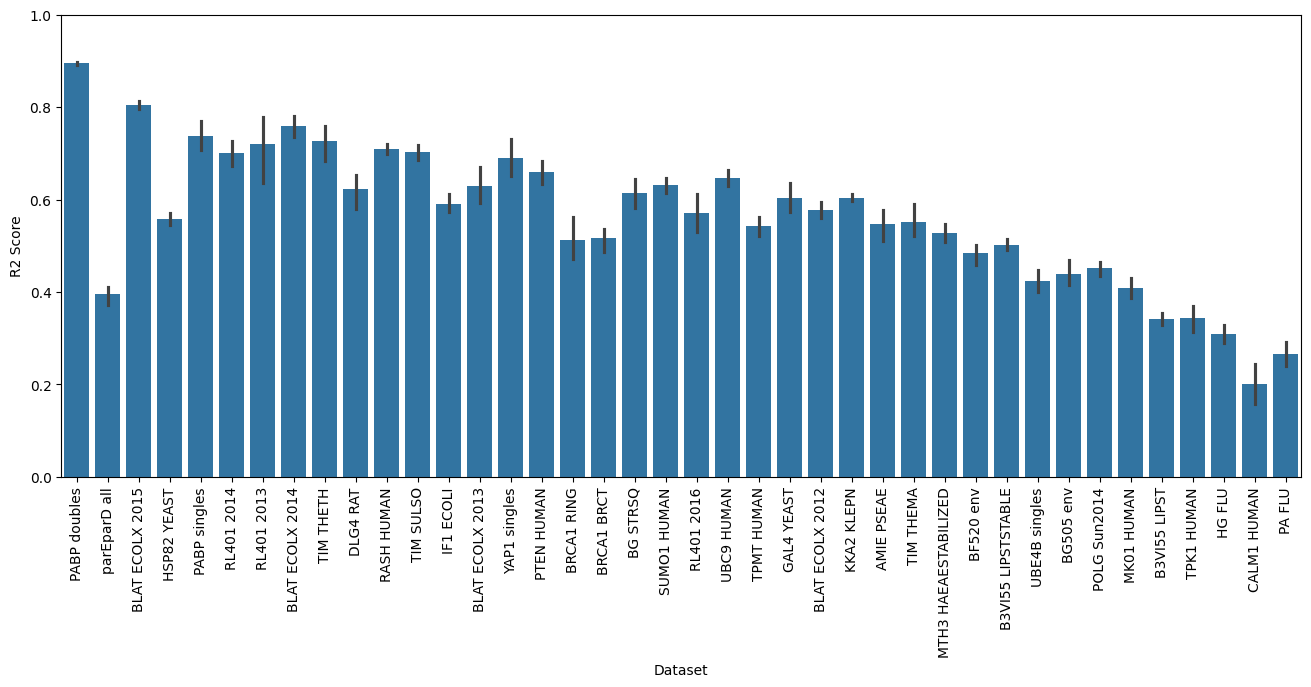

In [21]:

plt.figure(figsize=(16, 6))
sns.barplot(data=data, x='Dataset', y='rho_score_test')
plt.ylabel('R2_score_test')
plt.ylabel('R2 Score')
plt.xlabel('Dataset', )
plt.xticks(rotation=90)
plt.ylim(0, 1)
#plt.savefig('results/summary_DMS_all_LassoCV_esm2_150M_all_methods.png', dpi=600, bbox_inches='tight')
plt.show()

# PISCES compression

In [ ]:
data = pd.read_csv('results/summary_PISCES_lassoCV_esm2_150M_all_methods.csv', index_col=0)
data

In [ ]:
plt.figure(figsize=(6, 8))
sns.barplot(data=data, y='Dataset', x='R2_score_test')
plt.ylabel('R2_score_test')
plt.ylabel('')
plt.xlabel('R2 Score')
#plt.savefig('results/summary_PISCES_all_LassoCV_esm2_150M_mean.png', dpi=600, bbox_inches='tight')
plt.show()

# Multi Model Results

In [3]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Function to convert strings to numerical values
def convert_to_numeric(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

# Function to calculate Q1, Q2 (median), Q3
def calculate_quartiles(group):
    return pd.Series({
        "Q1": group['R2_score_test'].quantile(0.25),
        "Median": group['R2_score_test'].median(),
        "Q3": group['R2_score_test'].quantile(0.75),
        "parameters": group['parameters'].iloc[0]
    }) 


# Function to plot error bars
def plot_errorbars(data, color):
    data['lower_error'] = data['Median'] - data['Q1']
    data['upper_error'] = data['Q3'] - data['Median']
    
    plt.errorbar(
        x=data['parameters'],
        y=data['Median'],
        yerr=[data['lower_error'], data['upper_error']],
        fmt='-', color=color, capsize=3, elinewidth=1, markersize=1, linewidth=0.8
    )


def plot_scatter(data, color, label, marker):
    sns.scatterplot(data=data, x='parameters', y='Median', color=color, label=label, marker=marker)




cols_order = [
    'Dataset', 'Compression_method', 'Model', 'Fold', 'nun_zero_coefs', 
    'R2_score_train', 'MAE_score_train', 'RMSE_score_train', 'rho_score_train', 
    'R2_score_test', 'MAE_score_test', 'RMSE_score_test', 'rho_score_test',
    ]

## PISCES dataset

In [4]:
df = pd.DataFrame()
models = [
    'esm1v_650M', 
    'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B', 
    'esmc_300M', 'esmc_600M', 'esmc_6B', 
    'amplify_120M', 'amplify_350M']

for model in models:
    for file in os.listdir(f'results/lassoCV/PISCES/{model}'):
        if file.endswith('_mean.csv'):
            #target = re.split(r'_esm.*_', file)[0]
            target = " ".join(file.split('_')[:-3])
            data = pd.read_csv(f'results/lassoCV/PISCES/{model}/{file}', index_col=0)
            data['Model'] = model
            data['Dataset'] = target
            df = pd.concat([df, data])

df= df[cols_order].copy() 
df.reset_index(drop=True, inplace=True)
df

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test
0,SS H,mean,esm1v_650M,1,938,0.927262,0.037465,0.052801,0.956012,0.919686,0.038999,0.054764,0.950769
1,SS H,mean,esm1v_650M,2,949,0.927665,0.037322,0.052617,0.956157,0.919050,0.039424,0.055136,0.950460
2,SS H,mean,esm1v_650M,3,960,0.928309,0.037107,0.052094,0.956324,0.916120,0.040435,0.057369,0.951254
3,SS H,mean,esm1v_650M,4,954,0.927198,0.037327,0.052812,0.956444,0.920738,0.039389,0.054443,0.948609
4,SS H,mean,esm1v_650M,5,965,0.926950,0.037374,0.052609,0.955439,0.921982,0.039039,0.055232,0.954351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,PCP Instability index,mean,amplify_350M,1,714,0.537971,5.742499,7.471335,0.706656,0.484331,6.100517,8.001243,0.681169
716,PCP Instability index,mean,amplify_350M,2,735,0.534839,5.747759,7.493961,0.708386,0.501889,6.041488,7.873814,0.676656
717,PCP Instability index,mean,amplify_350M,3,695,0.530493,5.768330,7.524303,0.704622,0.510084,6.014921,7.828010,0.688436
718,PCP Instability index,mean,amplify_350M,4,721,0.530332,5.787748,7.544147,0.704927,0.511769,5.935376,7.738422,0.687825


In [5]:
df[['Model', 'ModelSize']] = df['Model'].str.split('_', expand=True)
df['parameters'] = df['ModelSize'].apply(convert_to_numeric)
df

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test,ModelSize,parameters
0,SS H,mean,esm1v,1,938,0.927262,0.037465,0.052801,0.956012,0.919686,0.038999,0.054764,0.950769,650M,650000000.0
1,SS H,mean,esm1v,2,949,0.927665,0.037322,0.052617,0.956157,0.919050,0.039424,0.055136,0.950460,650M,650000000.0
2,SS H,mean,esm1v,3,960,0.928309,0.037107,0.052094,0.956324,0.916120,0.040435,0.057369,0.951254,650M,650000000.0
3,SS H,mean,esm1v,4,954,0.927198,0.037327,0.052812,0.956444,0.920738,0.039389,0.054443,0.948609,650M,650000000.0
4,SS H,mean,esm1v,5,965,0.926950,0.037374,0.052609,0.955439,0.921982,0.039039,0.055232,0.954351,650M,650000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,PCP Instability index,mean,amplify,1,714,0.537971,5.742499,7.471335,0.706656,0.484331,6.100517,8.001243,0.681169,350M,350000000.0
716,PCP Instability index,mean,amplify,2,735,0.534839,5.747759,7.493961,0.708386,0.501889,6.041488,7.873814,0.676656,350M,350000000.0
717,PCP Instability index,mean,amplify,3,695,0.530493,5.768330,7.524303,0.704622,0.510084,6.014921,7.828010,0.688436,350M,350000000.0
718,PCP Instability index,mean,amplify,4,721,0.530332,5.787748,7.544147,0.704927,0.511769,5.935376,7.738422,0.687825,350M,350000000.0


In [6]:
df.to_csv('results/lassoCV/PISCES/summary_PISCES_all_multi_model.csv')
df = pd.read_csv('results/lassoCV/PISCES/summary_PISCES_all_multi_model.csv', index_col=0)
df

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test,ModelSize,parameters
0,SS H,mean,esm1v,1,938,0.927262,0.037465,0.052801,0.956012,0.919686,0.038999,0.054764,0.950769,650M,650000000.0
1,SS H,mean,esm1v,2,949,0.927665,0.037322,0.052617,0.956157,0.919050,0.039424,0.055136,0.950460,650M,650000000.0
2,SS H,mean,esm1v,3,960,0.928309,0.037107,0.052094,0.956324,0.916120,0.040435,0.057369,0.951254,650M,650000000.0
3,SS H,mean,esm1v,4,954,0.927198,0.037327,0.052812,0.956444,0.920738,0.039389,0.054443,0.948609,650M,650000000.0
4,SS H,mean,esm1v,5,965,0.926950,0.037374,0.052609,0.955439,0.921982,0.039039,0.055232,0.954351,650M,650000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,PCP Instability index,mean,amplify,1,714,0.537971,5.742499,7.471335,0.706656,0.484331,6.100517,8.001243,0.681169,350M,350000000.0
716,PCP Instability index,mean,amplify,2,735,0.534839,5.747759,7.493961,0.708386,0.501889,6.041488,7.873814,0.676656,350M,350000000.0
717,PCP Instability index,mean,amplify,3,695,0.530493,5.768330,7.524303,0.704622,0.510084,6.014921,7.828010,0.688436,350M,350000000.0
718,PCP Instability index,mean,amplify,4,721,0.530332,5.787748,7.544147,0.704927,0.511769,5.935376,7.738422,0.687825,350M,350000000.0


In [7]:
df_esm1 = df.query('Model == "esm1v"').copy()

df_esm2 = df.query('Model == "esm2"').copy()

df_esmc = df.query('Model == "esmc"').copy()

df_amplify = df.query('Model == "amplify"').copy()
df_amplify.head()

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test,ModelSize,parameters
600,PCP Hydrophobicity,mean,amplify,1,530,0.943027,0.052769,0.068663,0.963606,0.936427,0.055153,0.072226,0.959698,120M,120000000.0
601,PCP Hydrophobicity,mean,amplify,2,524,0.941926,0.053193,0.069351,0.963105,0.941143,0.053532,0.069361,0.962849,120M,120000000.0
602,PCP Hydrophobicity,mean,amplify,3,524,0.943115,0.052895,0.068844,0.963922,0.935506,0.054896,0.071711,0.958352,120M,120000000.0
603,PCP Hydrophobicity,mean,amplify,4,521,0.942168,0.052809,0.068815,0.963310,0.939326,0.054962,0.072040,0.961745,120M,120000000.0
604,PCP Hydrophobicity,mean,amplify,5,529,0.942103,0.053059,0.069026,0.963258,0.939367,0.054399,0.071321,0.961457,120M,120000000.0


In [8]:
cols = ['R2_score_test', 'parameters']
quartiles_esm1 = df_esm1.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2 = df_esm2.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2.sort_values('parameters', inplace=True)
quartiles_esmc = df_esmc.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_amplify = df_amplify.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2

,ModelSize,Q1,Median,Q3,parameters
5,8M,0.780261,0.809143,0.898779,8.000000e+06
2,35M,0.764936,0.829091,0.923753,3.500000e+07
0,150M,0.800158,0.885395,0.942080,1.500000e+08
4,650M,0.791308,0.891683,0.945935,6.500000e+08
3,3B,0.762480,0.902178,0.939506,3.000000e+09
1,15B,0.804157,0.932485,0.946521,1.500000e+10


/stor/work/Wilke/luiz/SWAT/venv3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


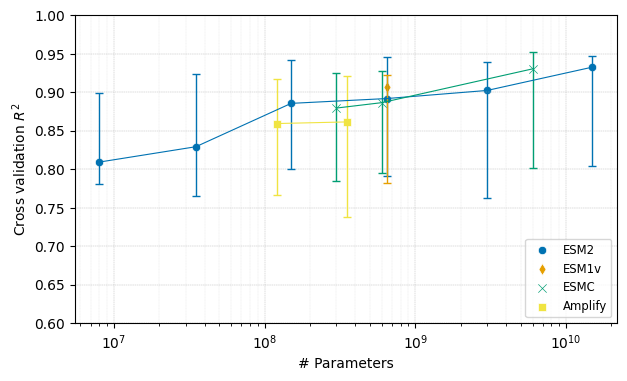

In [10]:
plt.figure(figsize=(7, 4))
#plt.title('PISCES Dataset')

plot_scatter(quartiles_esm2, color='#0072B2', label='ESM2', marker='o')
plot_errorbars(quartiles_esm2, color='#0072B2')

plot_scatter(quartiles_esm1, color='#E69F00', label='ESM1v', marker='d')
plot_errorbars(quartiles_esm1, color='#E69F00')

plot_scatter(quartiles_esmc, color='#009E73', label='ESMC', marker='x')
plot_errorbars(quartiles_esmc, color='#009E73')

plot_scatter(quartiles_amplify, color='#F0E442', label='Amplify', marker='s')
plot_errorbars(quartiles_amplify, color='#F0E442')

plt.ylabel('Cross validation $R^2$')
plt.xlabel('# Parameters')
plt.xscale('log')
plt.ylim(0.6, 1)
plt.legend(markerscale=1, fontsize='small', labelspacing=0.5, loc='lower right')
plt.grid(True, which='major', linestyle='--', linewidth=0.3)
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)

plt.savefig('results/lassoCV/PISCES/PISCES_multi_model.png', dpi=600, bbox_inches='tight')
plt.show()

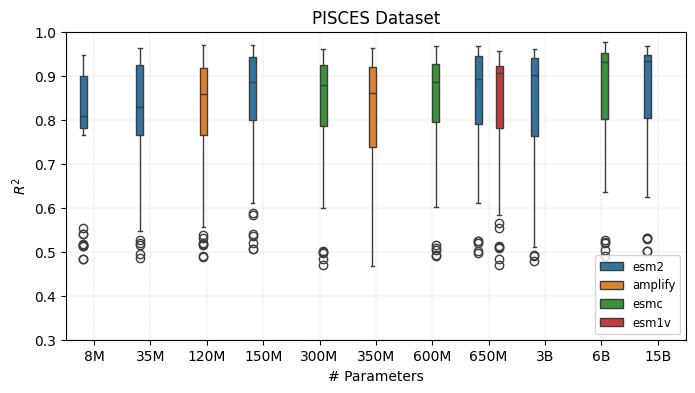

In [21]:
#df.loc[df['Model'] == 'esm1v', 'parameters'] -= 10000

plt.figure(figsize=(8, 4))
plt.title('PISCES Dataset')

#sns.boxplot(data=df, x='parameters', y='R2_score_test', width=0.3, hue='Model', dodge=False)
sns.boxplot(data=df, x='parameters', y='R2_score_test', width=0.5, hue='Model')

plt.ylabel('$R^2$')
plt.xlabel('# Parameters')
plt.ylim(0.3, 1)
plt.legend(fontsize='small', loc='lower right')

plt.grid(True, which='both', linestyle='--', linewidth=0.2)

ticks = plt.gca().get_xticks()
labels = ['8M', '35M', '120M', '150M', '300M', '350M', '600M', '650M', '3B', '6B', '15B']
#labels = ['8M', '35M', '120M', '150M', '300M', '350M', '600M', '650M', '650M','3B', '6B', '15B']
plt.xticks(ticks, labels)
#plt.xticks(rotation=90)
#plt.xscale('log')

plt.savefig('results/lassoCV/PISCES/PISCES_multi_model_3.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
stop

## DMS datasets

In [11]:
df = pd.DataFrame()
models = [
    'esm1v_650M', 
    'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B', 
    'esmc_300M', 'esmc_600M', 'esmc_6B', 
    'amplify_120M', 'amplify_350M']

base_dir = 'results/lassoCV/DMS'
for model in models:
    for file in os.listdir(f'{base_dir}/{model}'):
        if file.endswith('_mean.csv'):
            #target = re.split(r'_esm.*_', file)[0]
            #target = " ".join(file.split('_mean.csv')[:-3])
            target = file.split('_mean.csv')[0]
            data = pd.read_csv(f'{base_dir}/{model}/{file}', index_col=0)
            data['Model'] = model
            data['Dataset'] = target
            df = pd.concat([df, data])

df.reset_index(drop=True, inplace=True)
df

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
0,esm1v_650M,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017
1,esm1v_650M,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017
2,esm1v_650M,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017
3,esm1v_650M,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017
4,esm1v_650M,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify_350M,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013
2361,amplify_350M,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013
2362,amplify_350M,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013
2363,amplify_350M,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013


In [12]:
table = df.groupby(['Model'])[['R2_score_test', 'rho_score_test',  'MAE_score_test', 'RMSE_score_test']].mean()
table.round(3)

,R2_score_test,rho_score_test,MAE_score_test,RMSE_score_test
Model,,,,
amplify_120M,0.304,0.533,0.551,0.688
amplify_350M,0.293,0.527,0.562,0.697
esm1v_650M,0.370,0.587,0.500,0.624
esm2_150M,0.367,0.563,0.522,0.657
esm2_15B,0.400,0.618,0.511,0.643
esm2_35M,0.260,0.466,0.578,0.714
esm2_3B,0.342,0.567,0.531,0.665
esm2_650M,0.362,0.573,0.527,0.661
esm2_8M,0.192,0.393,0.608,0.741


In [13]:
df['Dataset_Name'] = df.apply(lambda row: name_map[row['Dataset']], axis=1)
df

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name
0,esm1v_650M,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN
1,esm1v_650M,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN
2,esm1v_650M,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN
3,esm1v_650M,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN
4,esm1v_650M,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify_350M,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013
2361,amplify_350M,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013
2362,amplify_350M,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013
2363,amplify_350M,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013


In [14]:
df[['Model', 'ModelSize']] = df['Model'].str.split('_', expand=True)
df['parameters'] = df['ModelSize'].apply(convert_to_numeric)
df

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters
0,esm1v,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
1,esm1v,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
2,esm1v,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
3,esm1v,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
4,esm1v,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2361,amplify,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2362,amplify,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2363,amplify,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0


In [ ]:
# df.to_csv('results/lassoCV/DMS/summary_DMS_all_multi_model.csv')
# df = pd.read_csv('results/lassoCV/DMS/summary_DMS_all_multi_model.csv', index_col=0)
# df

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters
0,esm1v,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
1,esm1v,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
2,esm1v,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
3,esm1v,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
4,esm1v,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2361,amplify,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2362,amplify,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2363,amplify,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0


In [16]:
DMS_longer=['BRCA1_HUMAN_RING', 'UBE4B_MOUSE_Klevit2013_singles', 'BRCA1_HUMAN_BRCT', 'POLG_HCVJF_Sun2014']
df_longer = df.query('Dataset in @DMS_longer').copy()
df_longer

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters
185,esm2,1,0.397855,0.500302,0.668820,0.376225,0.545541,0.737032,0.481485,0.591009,27,mean,BRCA1_HUMAN_RING,BRCA1 RING,8M,8000000.0
186,esm2,2,0.377641,0.523791,0.687013,0.433666,0.525417,0.682722,0.472487,0.518086,21,mean,BRCA1_HUMAN_RING,BRCA1 RING,8M,8000000.0
187,esm2,3,0.398098,0.513778,0.680673,0.362154,0.540794,0.704008,0.499117,0.449162,19,mean,BRCA1_HUMAN_RING,BRCA1 RING,8M,8000000.0
188,esm2,4,0.395849,0.522665,0.678161,0.284846,0.542226,0.761393,0.515590,0.352693,15,mean,BRCA1_HUMAN_RING,BRCA1 RING,8M,8000000.0
189,esm2,5,0.415121,0.518967,0.693730,0.253666,0.517702,0.642179,0.513393,0.373091,22,mean,BRCA1_HUMAN_RING,BRCA1 RING,8M,8000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,amplify,1,0.135808,0.318400,0.372639,0.122418,0.326773,0.384523,0.503568,0.507049,15,mean,POLG_HCVJF_Sun2014,POLG Sun2014,350M,350000000.0
2331,amplify,2,0.129320,0.323675,0.376338,0.124078,0.317273,0.375012,0.515662,0.475096,15,mean,POLG_HCVJF_Sun2014,POLG Sun2014,350M,350000000.0
2332,amplify,3,0.144848,0.321272,0.375344,0.109712,0.319686,0.367204,0.506287,0.402095,11,mean,POLG_HCVJF_Sun2014,POLG Sun2014,350M,350000000.0
2333,amplify,4,0.146023,0.318479,0.373534,0.135408,0.314393,0.369311,0.489514,0.471284,13,mean,POLG_HCVJF_Sun2014,POLG Sun2014,350M,350000000.0


In [17]:
df = df.query('Dataset not in @DMS_longer').copy()
df

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters
0,esm1v,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
1,esm1v,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
2,esm1v,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
3,esm1v,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
4,esm1v,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2361,amplify,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2362,amplify,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0
2363,amplify,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0


In [18]:
df_esm1 = df.query('Model == "esm1v"').copy()

df_esm2 = df.query('Model == "esm2"').copy()

df_esmc = df.query('Model == "esmc"').copy()

df_amplify = df.query('Model == "amplify"').copy()
df_amplify.head()

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters
1965,amplify,1,0.499670,0.263767,0.351897,0.365996,0.314663,0.409786,0.741287,0.662809,221,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,120M,120000000.0
1966,amplify,2,0.409825,0.291431,0.385292,0.415346,0.290954,0.381418,0.692757,0.695217,134,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,120M,120000000.0
1967,amplify,3,0.448499,0.281151,0.374451,0.315690,0.309668,0.403463,0.717673,0.595139,159,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,120M,120000000.0
1968,amplify,4,0.428854,0.289528,0.383520,0.373710,0.292675,0.375243,0.703021,0.646717,149,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,120M,120000000.0
1969,amplify,5,0.497704,0.270405,0.350186,0.238790,0.319508,0.460098,0.735047,0.605337,184,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,120M,120000000.0


In [19]:
# calculate quartiles
cols = ['R2_score_test', 'parameters']
quartiles_esm1 = df_esm1.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2 = df_esm2.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2.sort_values('parameters', inplace=True)
quartiles_esmc = df_esmc.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_amplify = df_amplify.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2

,ModelSize,Q1,Median,Q3,parameters
5,8M,0.091754,0.134228,0.236779,8.000000e+06
2,35M,0.152432,0.253353,0.342030,3.500000e+07
0,150M,0.248268,0.373403,0.528115,1.500000e+08
4,650M,0.268496,0.357181,0.469679,6.500000e+08
3,3B,0.244154,0.343362,0.449882,3.000000e+09
1,15B,0.349810,0.432258,0.504522,1.500000e+10


/stor/work/Wilke/luiz/SWAT/venv3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


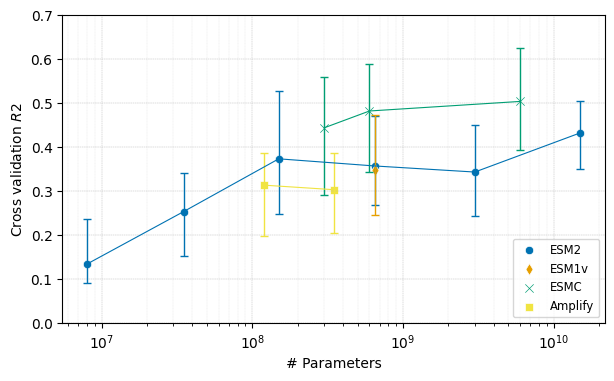

In [20]:
plt.figure(figsize=(7, 4))
#plt.title('DMS Datasets')

plot_scatter(quartiles_esm2, color='#0072B2', label='ESM2', marker='o')
plot_errorbars(quartiles_esm2, color='#0072B2')

plot_scatter(quartiles_esm1, color='#E69F00', label='ESM1v', marker='d')
plot_errorbars(quartiles_esm1, color='#E69F00')

plot_scatter(quartiles_esmc, color='#009E73', label='ESMC', marker='x')
plot_errorbars(quartiles_esmc, color='#009E73')

plot_scatter(quartiles_amplify, color='#F0E442', label='Amplify', marker='s')
plot_errorbars(quartiles_amplify, color='#F0E442')



plt.ylabel('Cross validation $R2$')
plt.xlabel('# Parameters')
plt.xscale('log')
plt.ylim(0, 0.7)
plt.legend(markerscale=1, fontsize='small', labelspacing=0.5, loc='lower right')
plt.grid(True, which='major', linestyle='--', linewidth=0.3)
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)

plt.savefig('results/lassoCV/DMS/DMS_multi_model.png', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
stop

NameError: name 'stop' is not defined

In [ ]:
plt.figure(figsize=(8, 4))
plt.title('DMS Dataset')

sns.boxplot(data=df, x='parameters', y='R2_score_test', width=0.5, hue='Model')


plt.ylabel('$R^2$')
plt.xlabel('# Parameters')
#plt.ylim(0, 1)
plt.legend(fontsize='small', loc='lower right')

plt.grid(True, which='both', linestyle='--', linewidth=0.2)

ticks = plt.gca().get_xticks()
labels = ['8M', '35M', '120M', '150M', '300M', '350M', '600M', '650M', '3B', '6B', '15B']
plt.xticks(ticks, labels)
#plt.xticks(rotation=90)

plt.savefig('results/lassoCV/DMS/DMS_multi_model_boxplot.png', dpi=600, bbox_inches='tight')
plt.show()

# DMS longer sequences

In [19]:
df_esm2 = df_longer.query('Model == "esm2"').copy()

df_esmc = df_longer.query('Model == "esmc"').copy()

df_amplify = df_longer.query('Model == "amplify"').copy()
df_amplify.head()

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters
2005,amplify,1,0.209797,0.567791,0.755479,0.192906,0.562721,0.731994,0.392719,0.406321,24,mean,BRCA1_HUMAN_BRCT,BRCA1 BRCT,120M,120000000.0
2006,amplify,2,0.285724,0.534261,0.713651,0.201751,0.532889,0.748318,0.475744,0.394364,44,mean,BRCA1_HUMAN_BRCT,BRCA1 BRCT,120M,120000000.0
2007,amplify,3,0.209662,0.555897,0.737331,0.192858,0.600171,0.804452,0.409590,0.383887,21,mean,BRCA1_HUMAN_BRCT,BRCA1 BRCT,120M,120000000.0
2008,amplify,4,0.210891,0.563910,0.752774,0.186992,0.580340,0.744106,0.404322,0.372552,18,mean,BRCA1_HUMAN_BRCT,BRCA1 BRCT,120M,120000000.0
2009,amplify,5,0.161556,0.590318,0.772770,0.175895,0.576397,0.761954,0.384227,0.409841,12,mean,BRCA1_HUMAN_BRCT,BRCA1 BRCT,120M,120000000.0


In [20]:
# calculate quartiles
cols = ['R2_score_test', 'parameters']
quartiles_esm2 = df_esm2.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2.sort_values('parameters', inplace=True)
quartiles_esmc = df_esmc.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_amplify = df_amplify.groupby('ModelSize')[cols].apply(calculate_quartiles).reset_index()
quartiles_esm2 

,ModelSize,Q1,Median,Q3,parameters
5,8M,0.069133,0.130664,0.261461,8.000000e+06
2,35M,0.055065,0.105162,0.191140,3.500000e+07
0,150M,0.171692,0.294013,0.421266,1.500000e+08
4,650M,0.148701,0.310342,0.450561,6.500000e+08
3,3B,0.098466,0.236580,0.349253,3.000000e+09
1,15B,0.186310,0.238256,0.326903,1.500000e+10


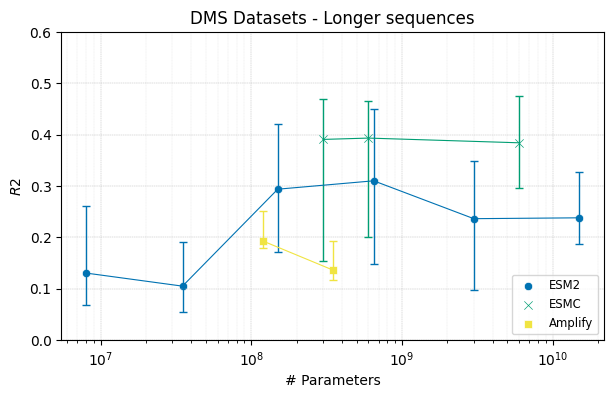

In [21]:
plt.figure(figsize=(7, 4))
plt.title('DMS Datasets - Longer sequences')

plot_scatter(quartiles_esm2, color='#0072B2', label='ESM2', marker='o')
plot_errorbars(quartiles_esm2, color='#0072B2')

plot_scatter(quartiles_esmc, color='#009E73', label='ESMC', marker='x')
plot_errorbars(quartiles_esmc, color='#009E73')

plot_scatter(quartiles_amplify, color='#F0E442', label='Amplify', marker='s')
plot_errorbars(quartiles_amplify, color='#F0E442')



plt.ylabel('$R2$')
plt.xlabel('# Parameters')
plt.xscale('log')
plt.ylim(0, 0.6)
plt.legend(markerscale=1, fontsize='small', labelspacing=0.5, loc='lower right')
plt.grid(True, which='major', linestyle='--', linewidth=0.3)
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)

plt.savefig('results/lassoCV/DMS/DMS_multi_model_longer_sequences.png', dpi=600, bbox_inches='tight')
plt.show()

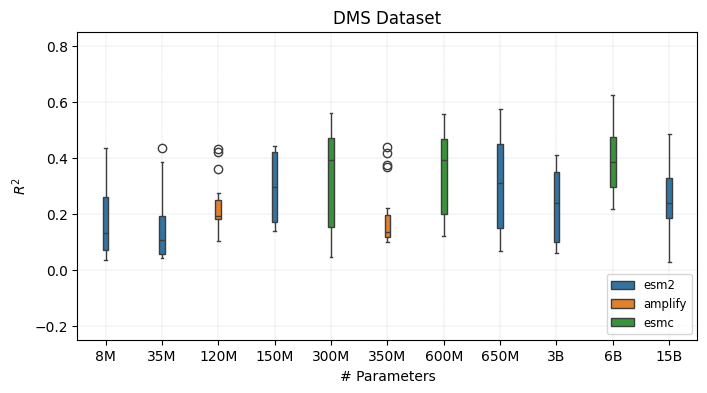

In [23]:
plt.figure(figsize=(8, 4))
plt.title('DMS Dataset')

sns.boxplot(data=df_longer, x='parameters', y='R2_score_test', width=0.1, hue='Model')


plt.ylabel('$R^2$')
plt.xlabel('# Parameters')
plt.ylim(-0.25, 0.85)
plt.legend(fontsize='small', loc='lower right')

plt.grid(True, which='both', linestyle='--', linewidth=0.2)

ticks = plt.gca().get_xticks()
labels = ['8M', '35M', '120M', '150M', '300M', '350M', '600M', '650M', '3B', '6B', '15B']
plt.xticks(ticks, labels)
#plt.xticks(rotation=90)

plt.savefig('results/lassoCV/DMS/DMS_multi_model_longer_sequences_boxplot.png', dpi=600, bbox_inches='tight')
plt.show()

In [13]:
stop

NameError: name 'stop' is not defined

# Sample size effect on predictions

## BLAT 2015 - Single Mutations

In [89]:
results = pd.DataFrame()
for model in ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B', 'esmc_300M', 'esmc_600M', 'amplify_120M', 'amplify_350M']:
    dta = pd.read_csv(f'results/lassoCV_sampling/BLAT_ECOLX_2015/BLAT_ECOLX_2015_sampling_{model}_mean.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    results = pd.concat([results, dta], axis=0)

results.reset_index(drop=True, inplace=True)
results[['Model', 'ModelSize']] = results['Model'].str.split('_', expand=True)
results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size,ModelSize
0,esm1v,1,6.766376e-01,0.530216,0.631664,-0.540406,1.110645,1.301045,0.835385,0.285714,10,32,650M
1,esm1v,2,9.854538e-01,0.115415,0.141277,-1.335611,1.006419,1.327997,0.973077,0.000000,24,32,650M
2,esm1v,3,7.757467e-01,0.451795,0.543609,0.569934,0.432107,0.647132,0.895385,0.942857,12,32,650M
3,esm1v,4,-2.220446e-15,0.935665,1.040120,-0.000140,1.286014,1.422127,NaN,NaN,0,32,650M
4,esm1v,5,9.936610e-01,0.071509,0.089630,-0.167253,1.041392,1.190601,0.968547,0.485714,29,32,650M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,amplify,1,7.281648e-01,0.478970,0.601135,0.629124,0.561037,0.697431,0.857471,0.809658,703,4996,350M
326,amplify,2,7.321346e-01,0.474092,0.595560,0.614931,0.568630,0.715948,0.858405,0.798823,723,4996,350M
327,amplify,3,7.254361e-01,0.481248,0.603037,0.632762,0.554683,0.699463,0.855726,0.800602,697,4996,350M
328,amplify,4,7.253009e-01,0.483519,0.604182,0.586464,0.586236,0.737245,0.856530,0.782538,665,4996,350M


In [ ]:
#data.to_csv('results/lassoCV_BLAT_ECOLX_2015/lassoCV_sampling/BLAT_ECOLX_2015_sampling_all_Models_mean.csv')

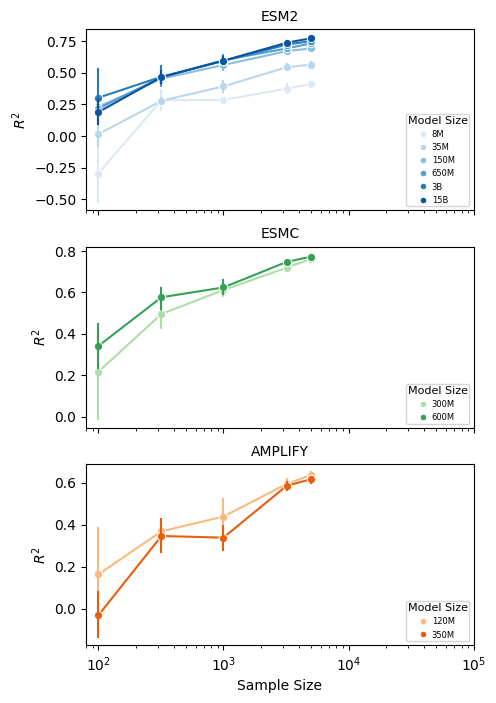

In [91]:
fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharex=True)
axes.flatten()

models = ['esm2', 'esmc', 'amplify']

for ax, model in zip(axes, models):
    data = results.query('Sample_size >=100')
    data = data.query(f'Model == "{model}"')
    
    if model == 'esm2':
        color = 'Blues'
    elif model == 'esmc':
        color = 'Greens'
    else:
        color = 'Oranges'
    
    ax.set_title(f"{model.upper()}", fontsize=10)
    sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='ModelSize', marker='o', err_style="bars", palette=color, legend=True, ax=ax)
    ax.set_ylabel('$R^2$')
    ax.set_xlabel('Sample Size')
    ax.set_xscale('log')
    ax.legend(title='Model Size', loc='lower right', title_fontsize=8, fontsize=6, markerscale=0.8, handlelength=0.5, borderpad=0.2)
    ax.set_xlim(left=80, right=100000)


#plt.savefig('results/lassoCV_sampling/HIS7/sampling_all_Models.png', dpi=600, bbox_inches='tight')
plt.show()

## PABP - Doubles Mutations

In [93]:
results = pd.DataFrame()
for model in ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B', 'esmc_300M', 'esmc_600M', 'amplify_120M', 'amplify_350M']:
    dta = pd.read_csv(f"results/lassoCV_sampling/PABP_doubles/PABP_doubles_sampling_{model}_mean.csv", index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    results = pd.concat([results, dta], axis=0)

results.reset_index(drop=True, inplace=True)
results[['Model', 'ModelSize']] = results['Model'].str.split('_', expand=True)
results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size,ModelSize
0,esm1v,1,-1.554312e-15,0.331271,0.383421,-0.192896,0.307287,0.362964,NaN,NaN,0,32,650M
1,esm1v,2,-4.218847e-15,0.264539,0.320799,-1.661057,0.515200,0.574096,NaN,NaN,0,32,650M
2,esm1v,3,-8.881784e-16,0.333107,0.389631,-1.095426,0.313835,0.337858,NaN,NaN,0,32,650M
3,esm1v,4,1.430052e-01,0.296668,0.345603,-0.181277,0.360618,0.393985,0.652650,0.085714,2,32,650M
4,esm1v,5,3.941832e-01,0.259773,0.308348,-0.278285,0.258291,0.311702,0.796239,-0.371429,2,32,650M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,amplify,1,7.432429e-01,0.154468,0.198198,0.729125,0.158364,0.204666,0.888008,0.884901,618,36521,350M
436,amplify,2,7.429261e-01,0.154567,0.198339,0.730572,0.157842,0.204039,0.888238,0.882679,617,36521,350M
437,amplify,3,7.444311e-01,0.154340,0.198042,0.725198,0.158808,0.204847,0.889623,0.876703,608,36521,350M
438,amplify,4,7.421050e-01,0.154397,0.198920,0.735221,0.158377,0.201149,0.887604,0.886299,620,36521,350M


In [ ]:
#data.to_csv('results/lassoCV_PABP_doubles/lassoCV_sampling/PABP_doubles_sampling_all_Models_mean.csv')

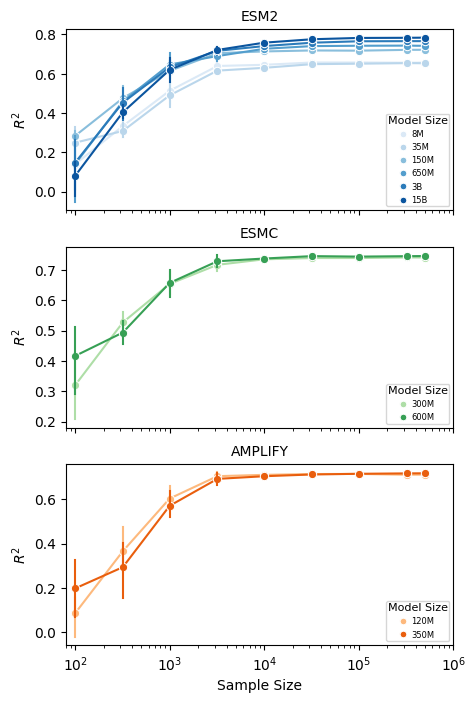

In [99]:
fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharex=True)
axes.flatten()

models = ['esm2', 'esmc', 'amplify']

for ax, model in zip(axes, models):
    data = results.query('Sample_size >=100')
    data = data.query(f'Model == "{model}"')
    
    if model == 'esm2':
        color = 'Blues'
    elif model == 'esmc':
        color = 'Greens'
    else:
        color = 'Oranges'
    
    ax.set_title(f"{model.upper()}", fontsize=10)
    sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='ModelSize', marker='o', err_style="bars", palette=color, legend=True, ax=ax)
    ax.set_ylabel('$R^2$')
    ax.set_xlabel('Sample Size')
    ax.set_xscale('log')
    ax.legend(title='Model Size', loc='lower right', title_fontsize=8, fontsize=6, markerscale=0.8, handlelength=0.5, borderpad=0.2)
    ax.set_xlim(left=80, right=1000000)


#plt.savefig('results/lassoCV_sampling/HIS7/sampling_all_Models.png', dpi=600, bbox_inches='tight')
plt.show()

## DMS HIS7 - Multiple mutation (1-28)

In [95]:
results = pd.DataFrame()
for model in ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B', 'esmc_300M', 'esmc_600M', 'amplify_120M', 'amplify_350M']:
    dta = pd.read_csv(f'results/lassoCV_sampling/HIS7/HIS7_sampling_{model}_mean.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    results = pd.concat([results, dta], axis=0)

results.reset_index(drop=True, inplace=True)
results[['Model', 'ModelSize']] = results['Model'].str.split('_', expand=True)
results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size,ModelSize
0,esm1v,1,5.008959e-01,0.262126,0.301604,-0.528276,0.547009,0.573769,0.793982,-0.433461,6,32,650M
1,esm1v,2,4.925876e-08,0.430087,0.449912,-0.045965,0.418240,0.437628,0.308932,-0.478634,1,32,650M
2,esm1v,3,0.000000e+00,0.430749,0.452345,-0.000844,0.383574,0.421980,NaN,NaN,0,32,650M
3,esm1v,4,-1.776357e-15,0.427461,0.444831,-0.204463,0.448542,0.462672,NaN,NaN,0,32,650M
4,esm1v,5,-2.220446e-16,0.430174,0.453914,-0.000397,0.387064,0.414600,NaN,NaN,0,32,650M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,amplify,1,7.175972e-01,0.184950,0.238698,0.717741,0.184397,0.238202,0.806314,0.802752,411,496137,350M
546,amplify,2,7.178707e-01,0.184877,0.238611,0.716804,0.184700,0.238480,0.806214,0.804131,403,496137,350M
547,amplify,3,7.182525e-01,0.184561,0.238262,0.714953,0.185868,0.240009,0.805268,0.807765,402,496137,350M
548,amplify,4,7.174709e-01,0.184720,0.238583,0.718551,0.184989,0.238534,0.805431,0.806550,412,496137,350M


In [ ]:
#data.to_csv('results/lassoCV_HIS7/lassoCV_sampling/HIS7_YEAST_sampling_all_Models_mean.csv')

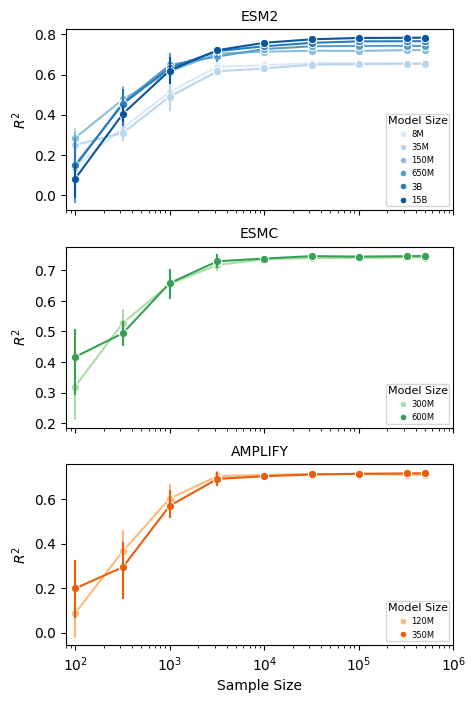

In [97]:
fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharex=True)
axes.flatten()

models = ['esm2', 'esmc', 'amplify']

for ax, model in zip(axes, models):
    data = results.query('Sample_size >=100')
    data = data.query(f'Model == "{model}"')
    
    if model == 'esm2':
        color = 'Blues'
    elif model == 'esmc':
        color = 'Greens'
    else:
        color = 'Oranges'
    
    ax.set_title(f"{model.upper()}", fontsize=10)
    sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='ModelSize', marker='o', err_style="bars", palette=color, legend=True, ax=ax)
    ax.set_ylabel('$R^2$')
    ax.set_xlabel('Sample Size')
    ax.set_xscale('log')
    ax.legend(title='Model Size', loc='lower right', title_fontsize=8, fontsize=6, markerscale=0.8, handlelength=0.5, borderpad=0.2)
    ax.set_xlim(left=80, right=1000000)


#plt.savefig('results/lassoCV_sampling/HIS7/sampling_all_Models.png', dpi=600, bbox_inches='tight')
plt.show()

## Merging files

In [ ]:
datasets = ['BLAT_ECOLX_2015', 'PABP_doubles', 'HIS7']

results = pd.DataFrame()
for dataset in datasets:
    for model in ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B', 'esmc_300M', 'esmc_600M', 'amplify_120M', 'amplify_350M']:
        dta = pd.read_csv(f'results/lassoCV_sampling/{dataset}/{dataset}_sampling_{model}_mean.csv', index_col=0)
        dta['Model'] = [model] * dta.shape[0]
        dta['Dataset'] = [dataset] * dta.shape[0]
        results = pd.concat([results, dta], axis=0)

results.reset_index(drop=True, inplace=True)
results[['Model', 'ModelSize']] = results['Model'].str.split('_', expand=True)

results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size,Dataset,ModelSize
0,esm1v,1,6.766376e-01,0.530216,0.631664,-0.540406,1.110645,1.301045,0.835385,0.285714,10,32,BLAT_ECOLX_2015,650M
1,esm1v,2,9.854538e-01,0.115415,0.141277,-1.335611,1.006419,1.327997,0.973077,0.000000,24,32,BLAT_ECOLX_2015,650M
2,esm1v,3,7.757467e-01,0.451795,0.543609,0.569934,0.432107,0.647132,0.895385,0.942857,12,32,BLAT_ECOLX_2015,650M
3,esm1v,4,-2.220446e-15,0.935665,1.040120,-0.000140,1.286014,1.422127,NaN,NaN,0,32,BLAT_ECOLX_2015,650M
4,esm1v,5,9.936610e-01,0.071509,0.089630,-0.167253,1.041392,1.190601,0.968547,0.485714,29,32,BLAT_ECOLX_2015,650M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,amplify,1,7.175972e-01,0.184950,0.238698,0.717741,0.184397,0.238202,0.806314,0.802752,411,496137,HIS7,350M
1316,amplify,2,7.178707e-01,0.184877,0.238611,0.716804,0.184700,0.238480,0.806214,0.804131,403,496137,HIS7,350M
1317,amplify,3,7.182525e-01,0.184561,0.238262,0.714953,0.185868,0.240009,0.805268,0.807765,402,496137,HIS7,350M
1318,amplify,4,7.174709e-01,0.184720,0.238583,0.718551,0.184989,0.238534,0.805431,0.806550,412,496137,HIS7,350M


In [6]:
#results.to_csv('results/summary_DMS4_sampling.csv')

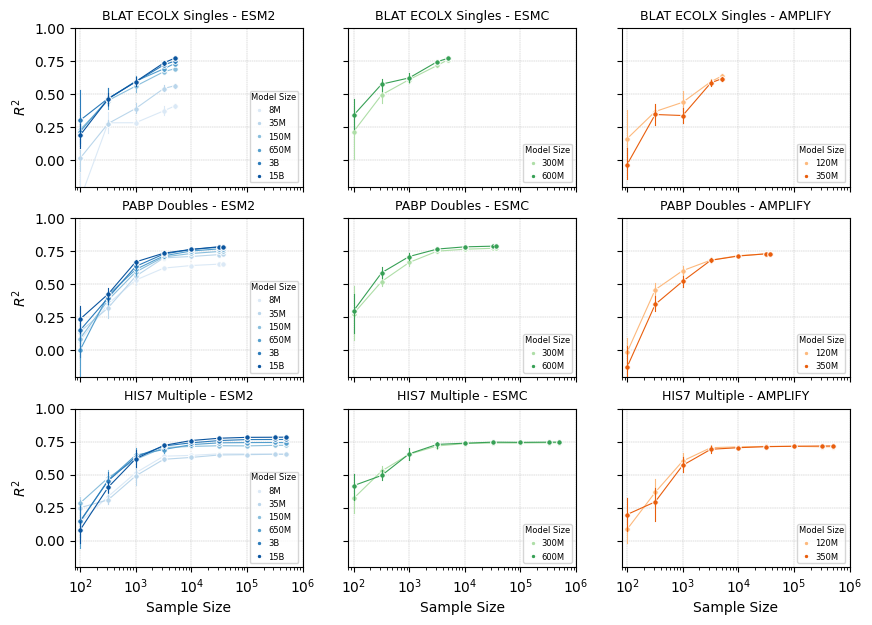

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7), sharex=True, sharey=True)
datasets = ['BLAT_ECOLX_2015', 'PABP_doubles', 'HIS7']  # Replace with your actual dataset names
models = ['esm2', 'esmc', 'amplify']

for row, dataset in enumerate(datasets):
    for col, model in enumerate(models):
        ax = axes[row, col]
        data = results.query('Sample_size >=100')
        data = data.query(f'Model == "{model}" & Dataset == "{dataset}"')  # Filter by dataset and model
        
        if model == 'esm2':
            color = 'Blues'
        elif model == 'esmc':
            color = 'Greens'
        else:
            color = 'Oranges'
        
        #titl = dataset.replace("_", " ").upper()
        if 'BLAT' in dataset:
            titl = 'BLAT ECOLX Singles'
        elif 'PABP' in dataset:
            titl = 'PABP Doubles'
        elif 'HIS7' in dataset:
            titl = 'HIS7 Multiple'

        ax.set_title(f"{titl} - {model.upper()}", fontsize=9)
        
        sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='ModelSize', marker='o', 
                     err_style="bars", palette=color, legend=True, ax=ax, linewidth=0.8, markersize=4,
                     err_kws={'elinewidth': 0.8, })
                    
        
        if row == 2:  # Label x-axis only for the last row
            ax.set_xlabel('Sample Size')
        else:
            ax.set_xlabel('')
        
        if col == 0:  # Label y-axis only for the first column
            ax.set_ylabel('$R^2$')
        else:
            ax.set_ylabel('')
        
        ax.set_xscale('log')
        ax.set_xlim(left=80, right=1000000)
        ax.set_ylim(-0.2,1)
        ax.grid(True, linestyle='--', linewidth=0.3)
        ax.legend(title='Model Size', loc='lower right', title_fontsize=6, fontsize=6, markerscale=0.8, handlelength=0.5, borderpad=0.2)
        #ax.grid(True, which='major', linestyle='--', linewidth=0.3)
        #ax.grid(True, which='minor', linestyle=':', linewidth=0.2)

#fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout and leave space for the legend

plt.savefig('results/lassoCV_sampling/lassoCV_sampling_all_models_and_datasets.png', dpi=600, bbox_inches='tight')
#plt.tight_layout()
plt.show()


## Feature importance

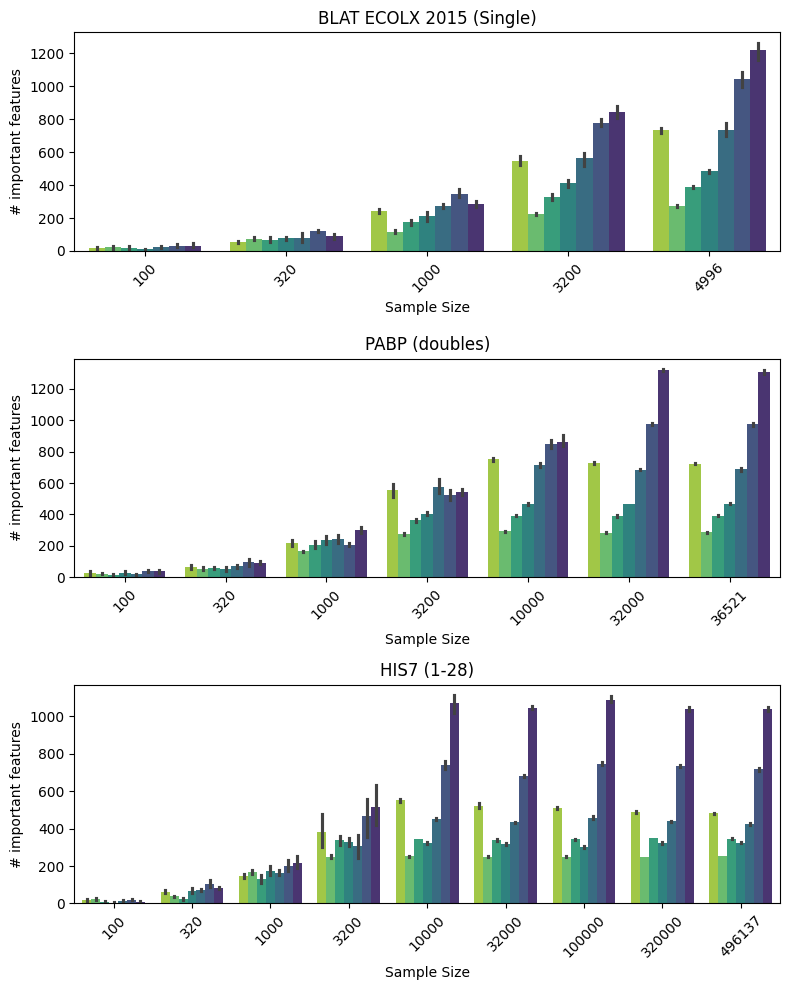

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8,10))
axes = axes.flatten()

datasets = ['BLAT_ECOLX_2015', 'PABP_doubles', 'HIS7_YEAST']
for ax, dms in zip(axes, datasets):
    res = pd.read_csv(f'results/lassoCV_{dms}/lassoCV_sampling/{dms}_sampling_all_Models_mean.csv', index_col=0)
    res = res.query('Sample_size >=100')
    #sns.lineplot(data=res, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars", palette='viridis_r', ax=ax, legend=False)
    sns.barplot(data=res, x='Sample_size', y='nun_zero_coefs', hue='Model',  palette=palette, ax=ax, legend=False)
    
    if dms == 'BLAT_ECOLX_2015':
        title = 'BLAT ECOLX 2015 (Single)'
    elif dms == 'PABP_doubles':
        title = 'PABP (doubles)'
    elif dms == 'parEparD_all':
        title = 'parEparD (1-4)'
    elif dms == 'HIS7_YEAST':
        title = 'HIS7 (1-28)'
    
    ax.set_title(title)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('# important features')
    ax.tick_params(axis='x', rotation=45)
 
# Add a single legend for the entire figure
#fig.legend(labels=models, loc='lower center', ncol=len(models), title='Model Size',)

plt.tight_layout()
#plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('results/summary_DMS3_sampling_important_features.png', dpi=600, bbox_inches='tight')
plt.show()

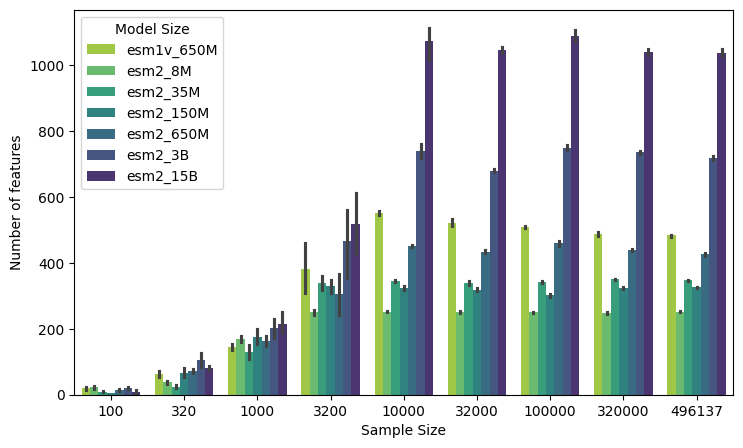

In [80]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.barplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model',  palette='viridis_r')
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='upper left')
#plt.xscale('log')
#plt.savefig('results/lassoCV_HIS7/HIS7_YEAST_Kondrashov2017_sampling_esm2_all_num_feature.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#data.to_csv('results/lassoCV_DMS/lassoCV_sampling/HIS7_YEAST_Kondrashov2017_sampling_esm2_all.csv')

# Sample size contribuition

In [21]:
#df_meta = pd.read_excel('data/DMS_metadata.xlsx')
df_meta = pd.read_csv('data/DMS_metadata.csv', index_col=0)
df_meta['Dataset_Name_used_HERE'] = df_meta['Dataset_Name_used_HERE'].str.rstrip().copy()
group_name = dict(zip(df_meta['Dataset_Name_used_HERE'], df_meta['Measurement']))
group_name

{'AMIE PSEAE': 'Enzyme function',
 'B3VI55 LIPST': 'Growth',
 'B3VI55 LIPSTSTABLE': 'Growth',
 'BF520 env': 'Viral replication',
 'BG STRSQ': 'Enzyme function',
 'BG505 env': 'Viral replication',
 'BLAT ECOLX 2012': 'Growth',
 'BLAT ECOLX 2013': 'MIC',
 'BLAT ECOLX 2014': 'Growth',
 'BLAT ECOLX 2015': 'Growth',
 'BRCA1 BRCT': 'Growth',
 'BRCA1 RING': 'Growth',
 'CALM1 HUMAN': 'Yeast growth',
 'DLG4 RAT': 'Peptide binding',
 'GAL4 YEAST': 'Growth',
 'HG FLU': 'Viral replication',
 'HIS7 YEAST': 'Growth',
 'HSP82 YEAST': 'Growth',
 'IF1 ECOLI': 'Growth',
 'KKA2 KLEPN': 'Growth',
 'MK01 HUMAN': 'Growth',
 'MTH3 HAEAESTABILIZED': 'Growth',
 'PA FLU': 'Viral replication',
 'PABP doubles': 'Growth',
 'PABP singles': 'Growth',
 'parEparD all': 'Growth',
 'POLG Sun2014': 'Viral replication',
 'PTEN HUMAN': 'Protein stability',
 'RASH HUMAN': 'Enzyme function',
 'RL401 2013': 'Growth',
 'RL401 2014': 'E1 reactivity',
 'RL401 2016': 'Growth',
 'SUMO1 HUMAN': 'Yeast growth',
 'TIM SULSO': 'Growth

In [22]:
dict_length = {}
dir = 'embeddings/DMS/esm2_150M/'
for file in os.listdir(dir):
    file_name = file
    l = len(os.listdir(f'{dir}/{file}'))
    dict_length[name_map[file_name]] = l

df = pd.DataFrame.from_dict(dict_length, orient='index').sort_values(0, ascending=True).reset_index()
df.rename(columns={'index': 'Dataset', 0: 'length'}, inplace=True)

df

,Dataset,length
0,YAP1 singles,362
1,BRCA1 RING,660
2,UBE4B singles,899
3,BLAT ECOLX 2013,989
4,PABP singles,1187
5,GAL4 YEAST,1195
6,RL401 2013,1269
7,RL401 2016,1324
8,RL401 2014,1435
9,IF1 ECOLI,1439


In [23]:
res = pd.read_csv(f'results/lassoCV/DMS/summary_DMS_all_multi_model.csv', index_col=0)
res['dataset_size'] = res.apply(lambda row: dict_length[row['Dataset_Name']], axis=1)
res['group'] = res.apply(lambda row: group_name[row['Dataset_Name']], axis=1)
res

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters,dataset_size,group
0,esm1v,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth
1,esm1v,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth
2,esm1v,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth
3,esm1v,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth
4,esm1v,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth
2361,amplify,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth
2362,amplify,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth
2363,amplify,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth


# Sequence length

In [24]:
from Bio import SeqIO

In [25]:
seq_length = {}

for file in os.listdir('data/DMS_mut_sequences'):
    fasta = SeqIO.parse(f'data/DMS_mut_sequences/{file}', 'fasta')
    dataset = file.split('_muts')[0]
    seq = str(list(fasta)[0].seq)
    seq_length[name_map[dataset]] = len(seq)
    
seq_length

{'BG505 env': 860,
 'MTH3 HAEAESTABILIZED': 331,
 'SUMO1 HUMAN': 101,
 'TPMT HUMAN': 245,
 'TPK1 HUMAN': 243,
 'IF1 ECOLI': 72,
 'PA FLU': 716,
 'AMIE PSEAE': 346,
 'RL401 2014': 128,
 'B3VI55 LIPST': 439,
 'PABP doubles': 577,
 'TIM THETH': 254,
 'RL401 2013': 128,
 'DLG4 RAT': 724,
 'parEparD all': 93,
 'TIM SULSO': 248,
 'BF520 env': 852,
 'UBE4B singles': 1173,
 'KKA2 KLEPN': 264,
 'PTEN HUMAN': 403,
 'RL401 2016': 128,
 'MK01 HUMAN': 360,
 'HG FLU': 565,
 'BLAT ECOLX 2012': 286,
 'BRCA1 RING': 1863,
 'BLAT ECOLX 2013': 286,
 'YAP1 singles': 504,
 'BLAT ECOLX 2014': 286,
 'GAL4 YEAST': 881,
 'PABP singles': 577,
 'B3VI55 LIPSTSTABLE': 439,
 'CALM1 HUMAN': 149,
 'POLG Sun2014': 3033,
 'BG STRSQ': 501,
 'BLAT ECOLX 2015': 286,
 'HSP82 YEAST': 709,
 'TIM THEMA': 252,
 'RASH HUMAN': 189,
 'UBC9 HUMAN': 159,
 'BRCA1 BRCT': 1863}

In [26]:
# sel = [
#     "CALM1 HUMAN",
#     "TIM THEMA", 
#     "AMIE PSEAE", 
#     "PTEN HUMAN", 
#     "PABP singles", 
#     "DLG4 RAT", 
#     "GAL4 YEAST", 
#     'UBE4B singles',
#     'BRCA1 RING',  
#     'BRCA1 BRCT',
#     'POLG Sun2014',
# ]

# pd.DataFrame.from_dict(seq_length, orient='index').sort_values(0, ascending=True).reset_index()#.query('index in @sel')

In [27]:
res['prot_length'] = res.apply(lambda row: seq_length[row['Dataset_Name']], axis=1)
res

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters,dataset_size,group,prot_length
0,esm1v,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth,159
1,esm1v,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth,159
2,esm1v,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth,159
3,esm1v,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth,159
4,esm1v,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Yeast growth,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2361,amplify,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2362,amplify,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2363,amplify,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128


In [35]:
res['group'] = res['group'].str.rstrip()

res['group'].replace('Yeast growth', 'Growth') 
res['group'].replace('E1 reactivity', 'Other') 
res['group'].replace('MIC', 'Other') 
res['group'].replace('Ligase activity', 'Other') 

print(res['group'].unique())
res

['Growth' 'Peptide binding' 'Viral replication' 'Other' 'Enzyme function'
 'Protein stability']


,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters,dataset_size,group,prot_length
0,esm1v,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
1,esm1v,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
2,esm1v,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
3,esm1v,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
4,esm1v,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2361,amplify,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2362,amplify,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2363,amplify,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128


In [36]:
#res.to_csv('results/lassoCV/DMS/DMS_all_multi_model_metadata.csv')

## Dataset size

In [37]:
results = pd.read_csv('results/lassoCV/DMS/DMS_all_multi_model_metadata.csv', index_col=0)   
results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset,Dataset_Name,ModelSize,parameters,dataset_size,group,prot_length
0,esm1v,1,0.521499,0.258196,0.344135,0.416348,0.299375,0.393177,0.751807,0.691086,187,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
1,esm1v,2,0.562205,0.246849,0.331845,0.463236,0.271668,0.365463,0.777234,0.701521,262,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
2,esm1v,3,0.577785,0.242628,0.327634,0.440030,0.276586,0.364972,0.784325,0.695573,254,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
3,esm1v,4,0.536516,0.257023,0.345487,0.468573,0.266481,0.345658,0.765695,0.702748,213,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
4,esm1v,5,0.608012,0.234794,0.309353,0.331150,0.295896,0.431284,0.798268,0.652083,290,mean,UBC9_HUMAN_Roth2017,UBC9 HUMAN,650M,650000000.0,2722,Growth,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,amplify,1,0.350944,0.207330,0.266071,0.305474,0.240362,0.312403,0.630929,0.654123,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2361,amplify,2,0.336148,0.219898,0.278957,0.281481,0.218982,0.282180,0.633886,0.581953,22,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2362,amplify,3,0.324581,0.224976,0.285680,0.308792,0.209852,0.255989,0.633801,0.579851,19,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128
2363,amplify,4,0.314953,0.223152,0.284795,0.277757,0.217834,0.276780,0.613730,0.622337,16,mean,RL401_YEAST_Bolon2013,RL401 2013,350M,350000000.0,1269,Growth,128


# Plot impact of sample size and protein length

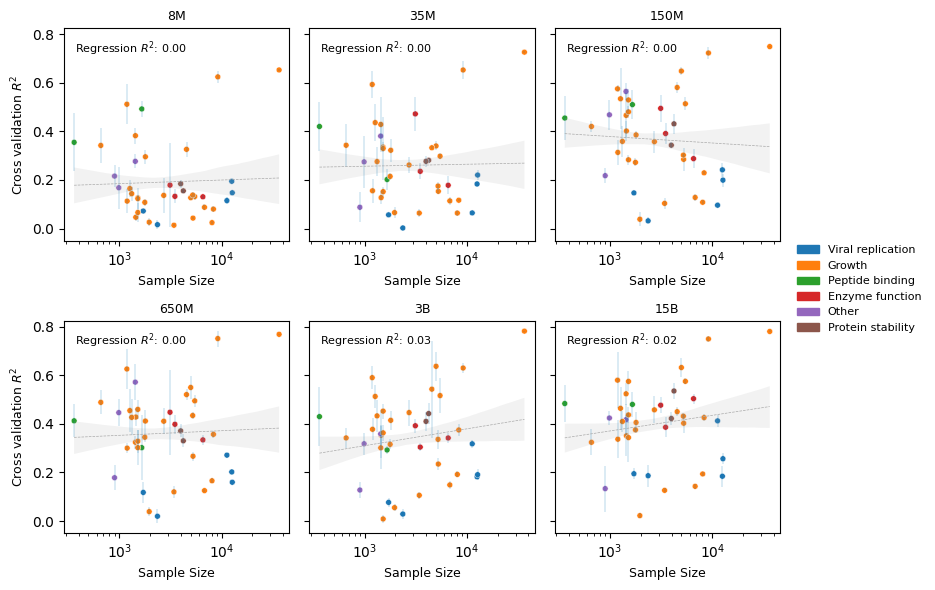

In [39]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches


res = results.query('Model=="esm2"')

fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharey=True)
axes = axes.flatten() 

#palette = sns.color_palette("muted", 11)  # or use a custom palette
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ffbb78']

group_labels = res['group'].unique()  # Get unique group labels
handles = [mpatches.Patch(color=palette[i], label=group_labels[i]) for i in range(len(group_labels))]


for ax, ms in zip(axes, ['8M', '35M', '150M', '650M', '3B', '15B']):
    data = res.query(f"ModelSize == '{ms}' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', 'dataset_size', 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x='dataset_size', y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data['dataset_size'], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data['dataset_size'].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    #sns.regplot(data=data, x='dataset_size', y='R2_score_test', scatter=False, logx=True,  color='#D55E00', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)
    sns.regplot(data=data, x='dataset_size', y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    ax.set_title(f'{t}', fontsize=9)
    ax.set_xlabel('Sample Size', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

#fig.legend(handles, group_labels, loc='lower center', ncol=2, fontsize=8, bbox_to_anchor=(0.7, 0.075), frameon=True)
fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.42), frameon=False)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_esm2_models_sample_size_effect.png', dpi=600, bbox_inches='tight')
plt.show()

## Protein Length

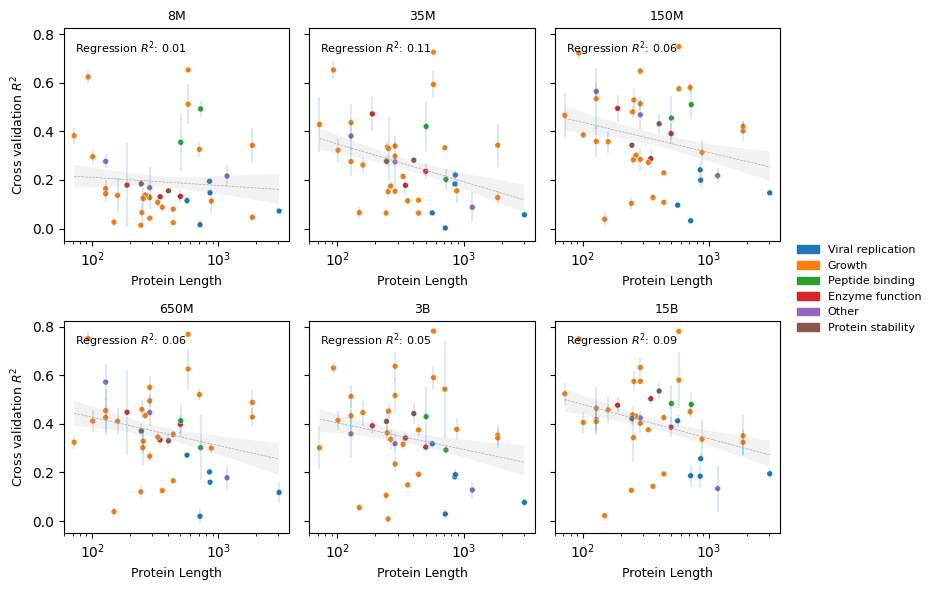

In [40]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches


fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharey=True)
axes = axes.flatten() 

for ax, ms in zip(axes, ['8M', '35M', '150M', '650M', '3B', '15B']):
    data = res.query(f"ModelSize == '{ms}' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', 'prot_length', 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x='prot_length', y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data['prot_length'], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data['prot_length'].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x='prot_length', y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    ax.set_title(f'{t}', fontsize=9)
    ax.set_xlabel('Protein Length', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.42), frameon=False)
#fig.legend(handles, group_labels, loc='lower center', ncol=7, fontsize=8, bbox_to_anchor=(0.52, 1.0), frameon=True)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_esm2_models_protein_length_effect.png', dpi=600, bbox_inches='tight')
plt.show()

## Sample size and protein length effect by model

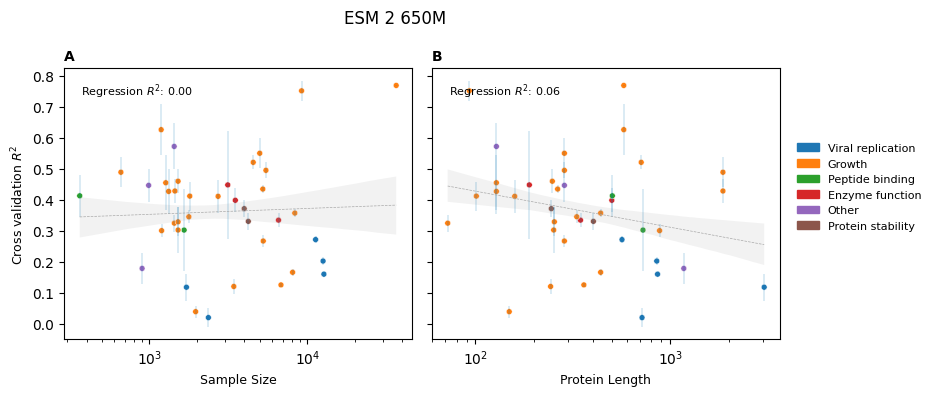

In [41]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches

res = results.query('Model=="esm2"')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten() 

plt.suptitle('ESM 2 650M')

for ax, grp in zip(axes, ['dataset_size', 'prot_length']):
    data = res.query(f"ModelSize == '650M' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', grp, 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x=grp, y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data[grp], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data[grp].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x=grp, y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    #ax.set_title(f'{t}', fontsize=9)
    t = 'B' if grp == 'prot_length' else 'A'
    l = 'Protein Length' if grp == 'prot_length' else 'Sample Size'
    ax.set_title(f'{t}', fontsize=10, fontweight='bold', loc='left')
    ax.set_xlabel(f'{l}', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.4), frameon=False)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_esm2_650M.png', dpi=600, bbox_inches='tight')
plt.show()

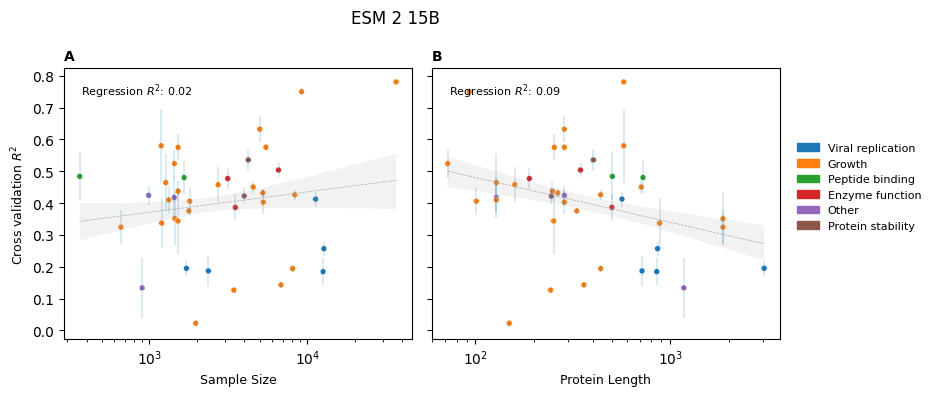

In [42]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches

res = results.query('Model=="esm2"')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten() 

plt.suptitle('ESM 2 15B')

for ax, grp in zip(axes, ['dataset_size', 'prot_length']):
    data = res.query(f"ModelSize == '15B' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', grp, 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x=grp, y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data[grp], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data[grp].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

      # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x=grp, y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    #ax.set_title(f'{t}', fontsize=9)
    t = 'B' if grp == 'prot_length' else 'A'
    l = 'Protein Length' if grp == 'prot_length' else 'Sample Size'
    ax.set_title(f'{t}', fontsize=10, fontweight='bold', loc='left')
    ax.set_xlabel(f'{l}', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.4), frameon=False)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_esm2_15B.png', dpi=600, bbox_inches='tight')
plt.show()

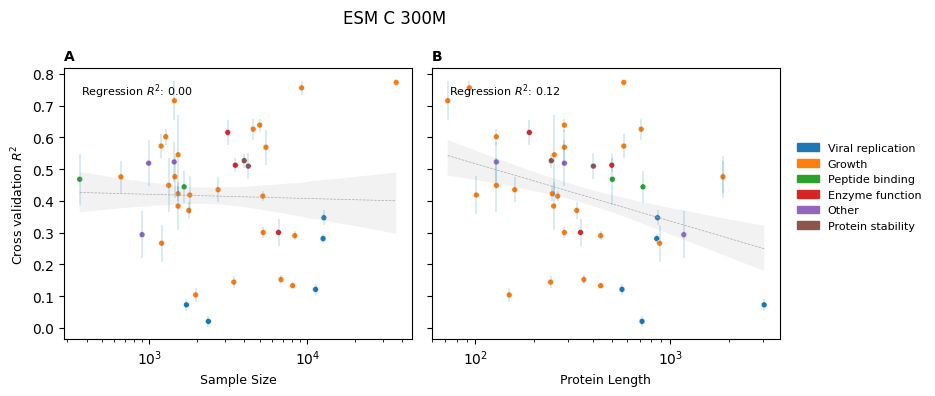

In [43]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches


res = results.query('Model=="esmc"')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten() 
plt.suptitle('ESM C 300M')
for ax, grp in zip(axes, ['dataset_size', 'prot_length']):
    data = res.query(f"ModelSize == '300M' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', grp, 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x=grp, y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data[grp], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data[grp].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

      # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x=grp, y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    #ax.set_title(f'{t}', fontsize=9)
    t = 'B' if grp == 'prot_length' else 'A'
    l = 'Protein Length' if grp == 'prot_length' else 'Sample Size'
    ax.set_title(f'{t}', fontsize=10, fontweight='bold', loc='left')
    ax.set_xlabel(f'{l}', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.4), frameon=False)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_esmc_300M.png', dpi=600, bbox_inches='tight')
plt.show()

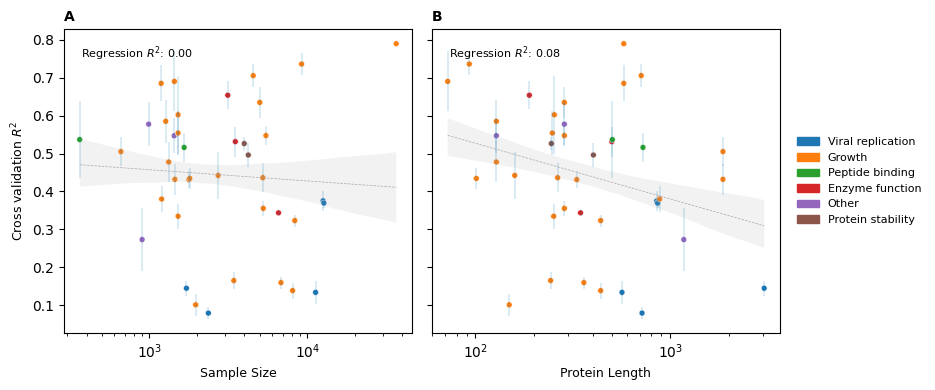

In [49]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches


res = results.query('Model=="esmc"')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten() 
#plt.suptitle('ESM C 600M')
for ax, grp in zip(axes, ['dataset_size', 'prot_length']):
    data = res.query(f"ModelSize == '600M' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', grp, 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x=grp, y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data[grp], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data[grp].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x=grp, y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    #ax.set_title(f'{t}', fontsize=9)
    t = 'B' if grp == 'prot_length' else 'A'
    l = 'Protein Length' if grp == 'prot_length' else 'Sample Size'
    ax.set_title(f'{t}', fontsize=10, fontweight='bold', loc='left')
    ax.set_xlabel(f'{l}', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.4), frameon=False)

plt.tight_layout()

fig.savefig('results/data_effect/DMS_esmc_600M.png', dpi=600, bbox_inches='tight')
plt.show()

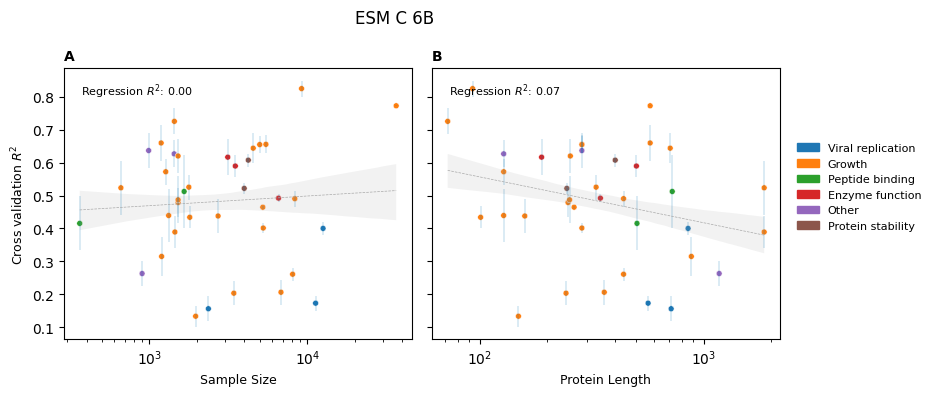

In [45]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches


res = results.query('Model=="esmc"')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten() 
plt.suptitle('ESM C 6B')
for ax, grp in zip(axes, ['dataset_size', 'prot_length']):
    data = res.query(f"ModelSize == '6B' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', grp, 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x=grp, y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data[grp], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data[grp].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x=grp, y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    #ax.set_title(f'{t}', fontsize=9)
    t = 'B' if grp == 'prot_length' else 'A'
    l = 'Protein Length' if grp == 'prot_length' else 'Sample Size'
    ax.set_title(f'{t}', fontsize=10, fontweight='bold', loc='left')
    ax.set_xlabel(f'{l}', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.4), frameon=False)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_esmc_6B.png', dpi=600, bbox_inches='tight')
plt.show()

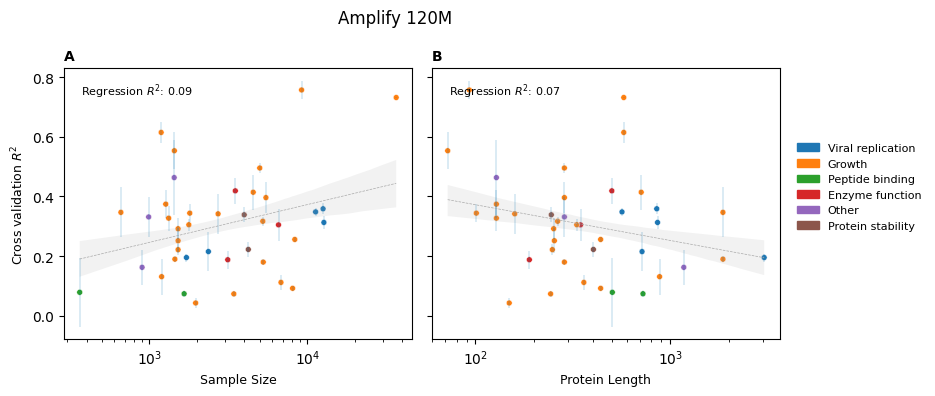

In [46]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches


res = results.query('Model=="amplify"')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten() 

plt.suptitle('Amplify 120M')

for ax, grp in zip(axes, ['dataset_size', 'prot_length']):
    data = res.query(f"ModelSize == '120M' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', grp, 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x=grp, y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data[grp], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data[grp].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

        # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x=grp, y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    #ax.set_title(f'{t}', fontsize=9)
    t = 'B' if grp == 'prot_length' else 'A'
    l = 'Protein Length' if grp == 'prot_length' else 'Sample Size'
    ax.set_title(f'{t}', fontsize=10, fontweight='bold', loc='left')
    ax.set_xlabel(f'{l}', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.4), frameon=False)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_Amplify_120M.png', dpi=600, bbox_inches='tight')
plt.show()

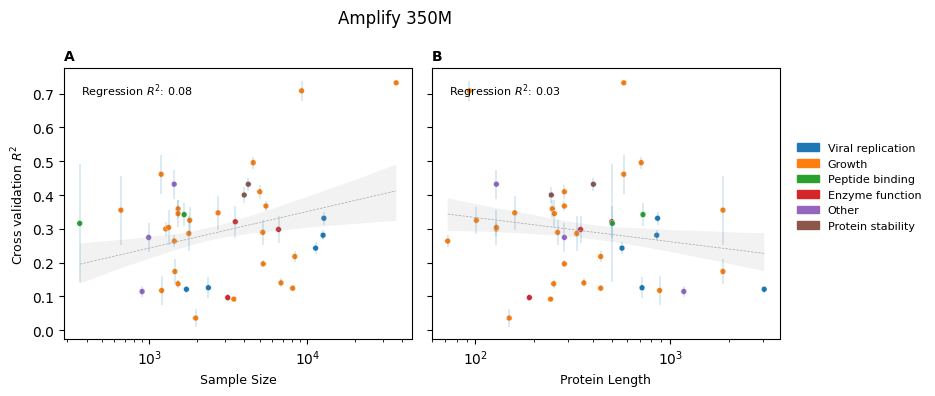

In [47]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches


res = results.query('Model=="amplify"')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten() 

plt.suptitle('Amplify 350M')

for ax, grp in zip(axes, ['dataset_size', 'prot_length']):
    data = res.query(f"ModelSize == '350M' & Compression_method == 'mean'")
    grouped_data = data.groupby(['Dataset', grp, 'group'])['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Map colors to the 'group' column
    color_map = {label: palette[i] for i, label in enumerate(group_labels)}
    scatter = sns.scatterplot(data=grouped_data, x=grp, y='mean', hue='group', palette=color_map,legend=False, s=18, ax=ax)
    ax.errorbar(grouped_data[grp], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=0, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)

    # Fit a linear regression model
    X = np.log(data[grp].values).reshape(-1, 1)  
    y = data['R2_score_test'].values
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

        # Annotate
    #ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Regression $R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    
    sns.regplot(data=data, x=grp, y='R2_score_test', scatter=False, logx=True,  color='#A9A9A9', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    t = ms.replace('_', ' ').upper()
    #ax.set_title(f'{t}', fontsize=9)
    t = 'B' if grp == 'prot_length' else 'A'
    l = 'Protein Length' if grp == 'prot_length' else 'Sample Size'
    ax.set_title(f'{t}', fontsize=10, fontweight='bold', loc='left')
    ax.set_xlabel(f'{l}', fontsize=9)
    ax.set_ylabel(r'Cross validation $R^2$', fontsize=9)
    ax.set_xscale('log')
    for ax in axes[7:]:
        ax.axis('off')

fig.legend(handles, group_labels, loc='lower center', ncol=1, fontsize=8, bbox_to_anchor=(1.08, 0.4), frameon=False)

plt.tight_layout()

#fig.savefig('results/data_effect/DMS_Amplify_350M.png', dpi=600, bbox_inches='tight')
plt.show()